# Machine Learning parte 2 Otimização com exploração aleatória

## Objetivos
* Explore espaços de parâmetros de forma aleatória
* Utilize o RandomizedSearch e otimize o tempo de busca
* Compare uma exploração exaustiva com aleatória
* Execute a otimização sem validação cruzada quando aplicável

Link: https://cursos.alura.com.br/course/machine-learning-otimizacao-com-exploracao-aleatoria

## Importando as bibliotecas necessárias

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, train_test_split, KFold, GroupKFold, GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.tree import export_graphviz
import graphviz

sns.set()

## Importando os dados

In [4]:
uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

df = pd.read_csv(uri, index_col=0)
df.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [5]:
X = df.drop('vendido', axis=1)
y = df['vendido']

seed = 301
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [6]:
df_azar = df.sort_values('vendido')
X_azar = df_azar.drop('vendido', axis=1)
y_azar = df_azar['vendido']

df_azar

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704
...,...,...,...,...
5491,71910.43,1,9,25778.40812
1873,30456.53,1,6,15468.97608
1874,69342.41,1,11,16909.33538
5499,70520.39,1,16,19622.68262


In [7]:
seed = 301
np.random.seed(seed)

dummy = DummyClassifier()
dummy.fit(X_train, y_train)
accuracy = dummy.score(X_test, y_test)

print(f'A Acurácia do modelo dummy stratified é: {accuracy:0.2%}')

A Acurácia do modelo dummy stratified é: 58.00%


In [9]:
seed = 301
np.random.seed(seed)

param_grid = {'max_depth': [3, 5],
              'min_samples_split': [32, 64, 128],
              'min_samples_leaf': [32, 64, 128],
              'criterion': ['gini', 'entropy']} 
modelo = DecisionTreeClassifier()

clf = RandomizedSearchCV(modelo, param_grid,
                   cv=KFold(n_splits=5, shuffle=True), n_iter=16)
clf.fit(X_azar, y_azar)
resultados = pd.DataFrame(clf.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012999,0.001265,0.003001,6.327868e-04,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.7755,0.7955,0.7895,0.7855,0.7740,0.7840,0.008210,12
1,0.011599,0.000800,0.002601,4.903695e-04,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7755,0.8030,0.7895,0.7855,0.7815,0.7870,0.009241,1
2,0.011000,0.001096,0.002201,4.006393e-04,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7755,0.8030,0.7895,0.7855,0.7815,0.7870,0.009241,1
3,0.019200,0.001328,0.002601,7.997397e-04,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.7755,0.7955,0.7895,0.7855,0.7755,0.7843,0.007859,7
4,0.021601,0.000800,0.003001,9.464947e-07,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7755,0.7955,0.7895,0.7855,0.7755,0.7843,0.007859,7


In [12]:
scores =  cross_val_score(clf, X_azar, y_azar, cv=KFold(n_splits=5, shuffle=True))
scores_mean = scores.mean()
score_std = scores.std()
print(f'Média da acurácia: {scores_mean}')
print(f'Intervalo da acurácia: [{scores_mean - 2 * score_std:0.2%} {scores_mean + 2 * score_std:0.2%}]')

Média da acurácia: 0.7868999999999999
Intervalo da acurácia: [77.05% 80.33%]


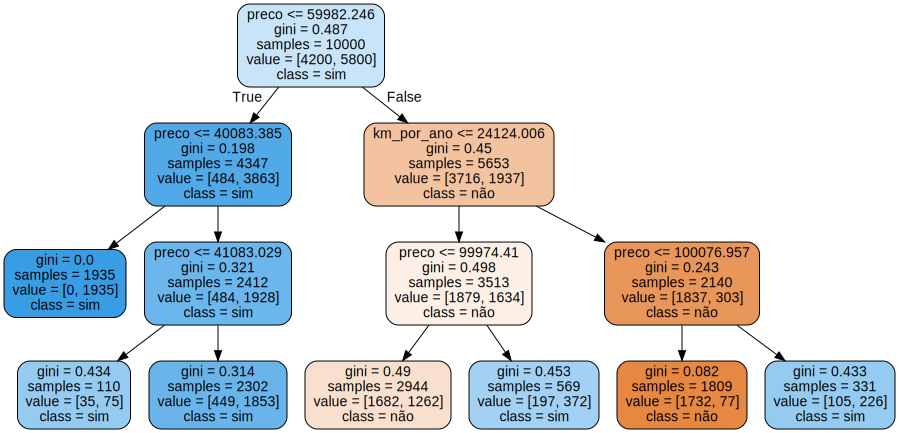

In [15]:
best = clf.best_estimator_

features = X_azar.columns
dot_data = export_graphviz(best, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph